In [7]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:99%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

# 1. LeNet : 최초의 CNN
```
<img src='image/LeNet.png' alt='LeNet'>
```
![LeNet](image/LeNet.png)

FC(120) : 120개 출력층의 뉴런을 가진 Fully Connected 레이어

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense
                                            # AveragePooling2D 동일
from tensorflow.keras.callbacks import EarlyStopping, Callback
import pandas as pd # crosstab
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self, times=5): # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.\
                 format(self.epoch, 
                        logs.get('loss'), 
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))

In [5]:
# 출력사이즈 = (입력사이즈 - 커널사이즈)/스트라이드 + 1
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1), activation='relu'):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(6, # 커널 갯수
                        kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal',
                        padding='valid'
                        )) # C1층
        model.add(AvgPool2D(pool_size=(2,2),
                           strides=2, # 스트라이드 사이즈는 기본이 pool_size
                           # strides=(2,2)
                           )) # P2층
        model.add(Conv2D(16, kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal')) # C3층
        model.add(AvgPool2D(pool_size=(2,2), strides=2)) # P4층
        model.add(Flatten())
        model.add(Dense(120, activation='relu', kernel_initializer='he_normal')) #F5층
        model.add(Dense(84, activation='relu', kernel_initializer='he_normal')) # F6층
        model.add(Dense(10, activation='softmax')) # 출력층
        return model

In [7]:
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1), activation='relu'):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(6, kernel_size=(5,5), activation=activation, 
                   kernel_initializer='he_normal'),
            AvgPool2D(pool_size=(2,2), strides=2),
            Conv2D(16, kernel_size=(5,5), activation=activation, 
                   kernel_initializer='he_normal'),
            AvgPool2D(pool_size=(2,2), strides=2),
            Flatten(),
            Dense(120, activation='relu', kernel_initializer='he_normal'),
            Dense(84, activation='relu', kernel_initializer='he_normal'),
            Dense(10, activation='softmax') # 출력층
        ])
        return model

In [8]:
model = LeNet.build(input_shape=(28,28,1), activation='relu')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [10]:
#  1. 데이터
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train = X_train.reshape(-1, 28,28,1)/255.0
X_test = X_test.reshape(-1, 28,28,1)/255.0
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [11]:
# 2.모델생성
model = LeNet.build(input_shape=(28,28,1))
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', # 원핫인코딩을 안 하고 분류분석
             optimizer='adam',
             metrics=['accuracy'])
# 4. 학습
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=10)
hist = model.fit(X_train, y_train,
                validation_split=0.2, 
                epochs=50,
                callbacks=[customHistory, earlystopping],
                verbose=0)

epoch:3, loss:0.05270559713244438, acc:0.9830416440963745, val_loss:0.06439472734928131, val_acc:0.9806666374206543
epoch:6, loss:0.02859506756067276, acc:0.9907500147819519, val_loss:0.04393176734447479, val_acc:0.9869999885559082
epoch:9, loss:0.017610644921660423, acc:0.9944166541099548, val_loss:0.043879423290491104, val_acc:0.9881666898727417
epoch:12, loss:0.013784471899271011, acc:0.9952499866485596, val_loss:0.03657058626413345, val_acc:0.9901666641235352
epoch:15, loss:0.009218198247253895, acc:0.996874988079071, val_loss:0.061979543417692184, val_acc:0.987583339214325
epoch:18, loss:0.006933334283530712, acc:0.9976041913032532, val_loss:0.07147443294525146, val_acc:0.9864166378974915


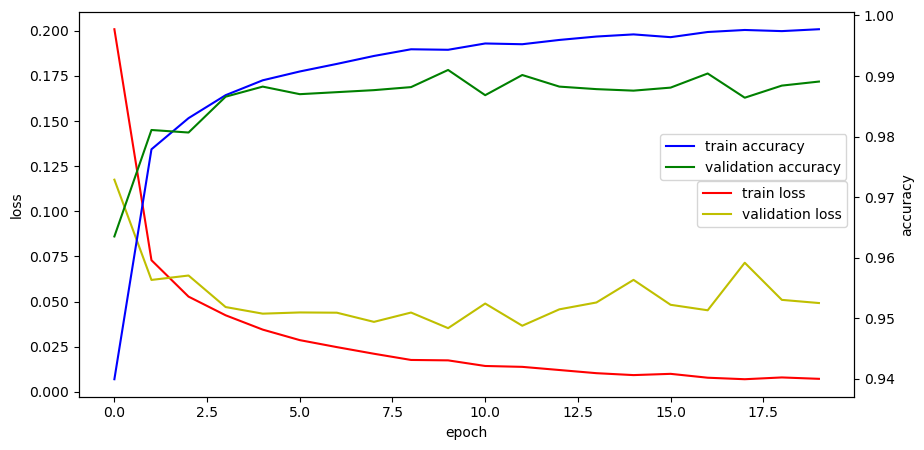

In [14]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print("accuracy : {:.2f}%".format(accuracy*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0432 - accuracy: 0.9898
accuracy : 98.98%


In [22]:
# 예측치와 실제값을 이용한 교차표
yhat = model.predict(X_test).argmax(axis=1)
display(pd.crosstab(y_test, yhat)) # 결과가 데이터프레임
# print(confusion_matrix(y_test, yhat)) # 결과가 넘파이배열
cnt = 0
for y, h in zip(y_test, yhat):
    if y!=h:
        cnt += 1
print('예측이 틀린 갯수 :', cnt)

313/313 [==============================] - 1s 2ms/step


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,0,1,0,0,0,1,1,0,3
1,0,1130,2,2,0,0,1,0,0,0
2,1,0,1024,0,0,0,0,5,2,0
3,0,0,1,1003,0,4,0,2,0,0
4,0,0,1,0,977,0,0,0,0,4
5,0,0,1,5,0,885,1,0,0,0
6,5,1,3,0,3,6,940,0,0,0
7,0,3,5,0,1,0,0,1010,1,8
8,1,0,2,1,1,1,0,0,967,1


예측이 틀린 갯수 : 102


i = 3423
cnt = 50


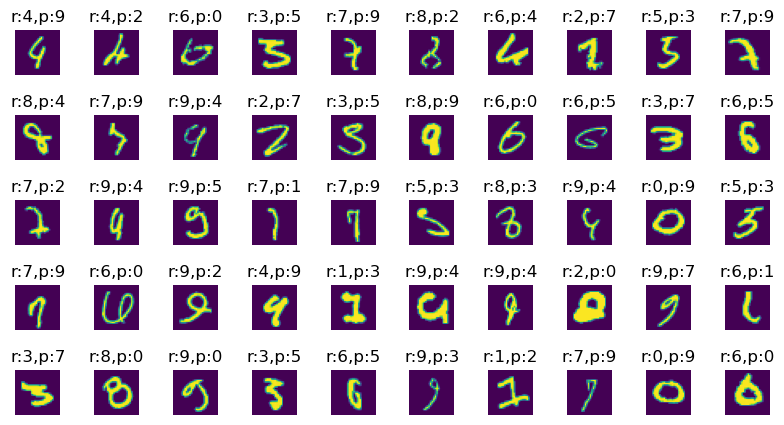

In [23]:
# 모델 학습 후 예측이 틀린 경우만 출력
plt_row = 5
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
# plt.rc('font', family='Malgun Gothic') # 윈도우즈 os
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.9, wspace=0.2)

i = 0 # yhat과 y_test를 액세스할 index
cnt = 0 # 출력할 횟수
while (cnt<plt_row*plt_col) & (i < len(y_test)):
    # 예측한 결과가 틀렸을 경우만 imshow(X_test[i]), 실제값과 예측치를 title에 출력
    if yhat[i]==y_test[i]:
        i += 1
        continue
    # 예측한 값과 실제값이 다른 경우
    sub_plot = axarr[cnt//plt_col, cnt%plt_col]
    sub_plot.imshow(X_test[i].reshape(28, 28))
    title = 'r:{},p:{}'.format(y_test[i], yhat[i])
    sub_plot.set_title(title)
    sub_plot.axis('off')
    i += 1
    cnt += 1
print('i =', i)
print('cnt =',cnt)

# 2. AlexNet
- GPU를 사용하여 실현 가능한 모델. 알렉스와 제프리힌튼이 공동 설계한 CNN 아키텍처 이름

In [26]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.10.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization # 배치정규화
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [11]:
# 출력사이즈 = (입력사이즈-커널사이즈)/스트라이드 + 1
class AlexNet:
    @staticmethod
    def build(input_shape=(224, 224, 3), activation='relu', class_num=1000):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(96, # 커널갯수
                  kernel_size=(11,11), strides=(4,4),activation=activation,
                  padding='same'),
            MaxPooling2D(pool_size=(3,3), strides=2),
            BatchNormalization(), # 배치 정규화
            Conv2D(256, kernel_size=(5,5), activation=activation,
                  padding='same'),
            MaxPooling2D(pool_size=(3,3), strides=2),
            BatchNormalization(),
            Conv2D(384, kernel_size=(3,3), activation=activation, 
                  padding='same'),
            Conv2D(384, kernel_size=(3,3), activation=activation, 
                  padding='same'),
            Conv2D(256, kernel_size=(3,3), activation=activation, 
                  padding='same'),
            # AlexNet은 224*224 이미지에 맞춰서 3*3 pooling이 되나,
            # cifar 32*32 이미지에서는 생략
            # MaxPooling2D(pool_size=(3,3), strides=2),
            Flatten(),
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=class_num, activation='softmax')
        ])
        return model

In [12]:
model = AlexNet.build(input_shape=(32,32,3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 3, 96)         0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 3, 3, 96)         384       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 3, 3, 256)         614656    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 1, 1, 256)        0         
 g2D)                                                            
                                                      

In [2]:
# 1. 데이터 (원핫인코딩 X)
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

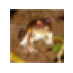

array([6], dtype=uint8)

In [19]:
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
plt.figure(figsize=(0.7,0.7))
plt.imshow(X_train[0])
plt.axis('off')
plt.show()
y_train[0]

In [23]:
# 스케일 조정
X_train = X_train/255.0
X_test  = X_test /255.0
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
# 2. 모델
# model = AlexNet.build(input_shape=(32,32,3), class_num=10) 학습시간 단축을 위해 아래 사용
model = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(96, # 커널갯수
          kernel_size=(11,11), strides=(4,4),activation='relu',
          padding='same'), # => 파라미터수 : 11*11*96*3(채널수) + 96(출력수) = 34,944
    MaxPooling2D(pool_size=(3,3), strides=2),
    BatchNormalization(), # 배치 정규화

    Conv2D(384, kernel_size=(3,3), activation='relu', 
          padding='same'), # => 파라미터수 : 96*3*3*384 + 384 = 332,160
    Conv2D(256, kernel_size=(3,3), activation='relu', 
          padding='same'), # => 파라미터수 : 384*3*3*256 + 256

    Flatten(),
    Dense(units=1024, activation='relu'),
    Dropout(0.3),
    Dense(units=512, activation='relu'),
    Dropout(0.3),
    Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 96)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 96)         384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 384)         332160    
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         884992    
                                                                 
 flatten (Flatten)           (None, 2304)              0

In [4]:
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', #원핫인코딩 안 했을 경우
             optimizer='adam',
             metrics=['accuracy'])
# 4. 학습
hist = model.fit(X_train, y_train, 
                epochs=20,
                validation_data=[X_test, y_test])

Epoch 1/20
1563/1563 [==============================] - 16s 9ms/step - loss: 1.6155 - accuracy: 0.4163 - val_loss: 1.5875 - val_accuracy: 0.4349
Epoch 2/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.3414 - accuracy: 0.5262 - val_loss: 1.3607 - val_accuracy: 0.5253
Epoch 3/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2086 - accuracy: 0.5795 - val_loss: 1.2726 - val_accuracy: 0.5501
Epoch 4/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1.1132 - accuracy: 0.6128 - val_loss: 1.3078 - val_accuracy: 0.5560
Epoch 5/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0290 - accuracy: 0.6441 - val_loss: 1.2458 - val_accuracy: 0.5871
Epoch 6/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9489 - accuracy: 0.6735 - val_loss: 1.2078 - val_accuracy: 0.5997
Epoch 7/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8771 - accuracy: 0.6941 - val_loss: 1.2494 - val_ac

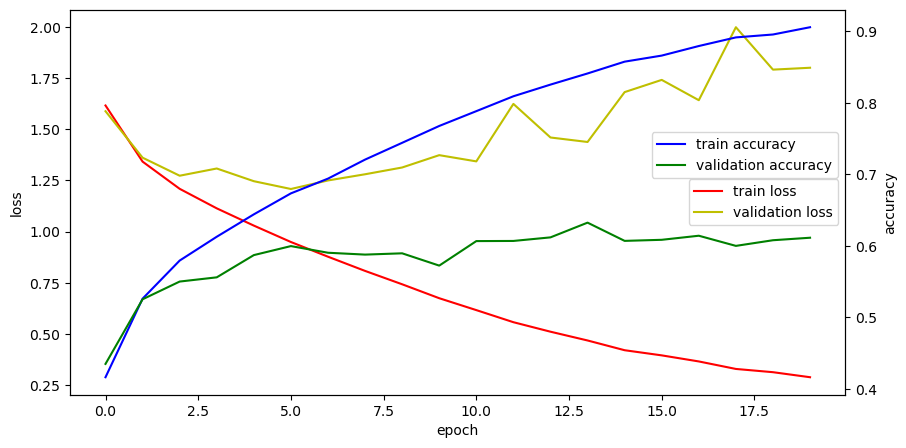

In [5]:
# 5. 모델 평가 - 학습과정 살펴보기, 모델 평가, 교차표
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [6]:
# 5. 모델 평가 
loss, accuracy = model.evaluate(X_test, y_test)
print('loss :', loss)
print('accuracy :', accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 1.7998 - accuracy: 0.6114
loss : 1.799774408340454
accuracy : 0.6114000082015991


In [15]:
# 5. 모델 평가 : 교차표
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# y_test.reshape(-1) # 실제값을 1차원으로 변경한 값
y_hat = np.argmax(model.predict(X_test), axis=1)
ctab = pd.crosstab(y_test.reshape(-1), y_hat)
ctab.columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
                     'horse', 'ship', 'truck']
ctab.columns.name = 'predict'
ctab.index = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
                     'horse', 'ship', 'truck']
ctab.index.name = 'real'
ctab

313/313 [==============================] - 1s 2ms/step


predict,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
real,,,,,,,,,,
airplane,758,55,29,14,24,7,5,5,56,47
automobile,27,764,6,13,5,5,3,2,26,149
bird,113,34,432,78,140,83,48,28,15,29
cat,42,26,68,388,101,247,53,26,12,37
deer,60,15,74,66,600,55,51,51,13,15
dog,23,13,48,153,78,573,30,49,12,21
frog,18,28,57,98,88,59,605,6,12,29
horse,53,17,35,46,92,84,8,610,9,46
ship,137,59,8,11,20,21,3,3,691,47


array([8], dtype=uint8)

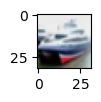

In [33]:
# 6. 모델 사용하기
plt.figure(figsize=(0.7,0.7))
plt.imshow(X_test[1])
y_test[1]

In [34]:
pred = model.predict(X_test[1].reshape(-1, 32,32,3)).argmax(axis=1)
pred

1/1 [==============================] - 0s 17ms/step


array([8], dtype=int64)

# 3. VGGNet
- 옥스퍼드 대 VGG팀에서 구현한 CNN(컨볼루션과 맥스폴링 19개층)
- VGG-19 구현

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
import cv2 # pip install opencv-python : 이미지 사이즈 조정
import matplotlib.pyplot as plt

In [2]:
class Vgg19:
    @staticmethod
    def build(input_shape=(224,224,3), activation='relu'):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3,3), activation=activation, padding='same'),
            Conv2D(64, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(128, (3,3), activation=activation, padding='same'),
            Conv2D(128, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            Conv2D(256, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            Conv2D(512, (3,3), activation=activation, padding='same'),
            MaxPooling2D(),
            Flatten(),
            Dense(4096, activation='relu'),
            Dense(4096, activation='relu'),
            Dense(1000, activation='softmax')
        ])
        return model

In [3]:
model = Vgg19.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [4]:
vggModel = VGG19() # 학습을 하지 않고 imageNet으로 학습이 끝난 model&weights 내려받아 가중치만 사용
weights = vggModel.get_weights()
model.set_weights(weights=weights) # 학습이 끝난 가중치를 model에 이식
# 추가적인 재학습도 가능함

574710816/574710816 [==============================] - 152s 0us/step


In [11]:
# model.predict(읽어온이미지를 224*224*3 넘파이배열)
# 예측하기 위해 이미지를 읽어 -> 사이즈 조정(openCV라이브러리: pip install opencv-python)
# 방법 1
img_cv2 = cv2.imread('data/sample.jpg',
                    cv2.IMREAD_COLOR, # BGR포맷, 알파(투명도)채널 무시
                    # cv2.IMREAD_UNCHANGED, # 투명도까지 그대로 읽음
                    # cv2.IMREAD_GRAYSCALE # 흑백으로 읽음
                    )
img_cv2 = cv2.resize(img_cv2, dsize=(224,224),# INTER_NEAREST 보간법을 이용하여 사이즈조정
                    interpolation=cv2.INTER_NEAREST) 

cv2.imshow('sample', img_cv2)
cv2.waitKey(0) # 키보드입력을 기다림. 이미지가 화면에 표시된 상태를 유지
cv2.destroyAllWindows() # openCV를 통해 생성된 모든 창을 닫음
img_cv2.shape

(224, 224, 3)

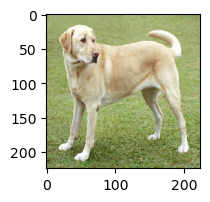

numpy.ndarray

In [15]:
plt.figure(figsize=(2,2))
# BGR 포맷인 img_cv2를 RGB 포맷으로
img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv2_rgb)
plt.show()
type(img_cv2_rgb)

In [18]:
# 방법2
from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg', target_size=(224,224))
print(type(img))
img_data = image.img_to_array(img)
print('읽어온 img_data의 type :', type(img_data), ', img_data의 shape :', img_data.shape)

<class 'PIL.Image.Image'>
읽어온 img_data의 type : <class 'numpy.ndarray'> , img_data의 shape : (224, 224, 3)


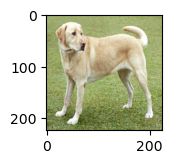

In [21]:
plt.figure(figsize=(1.5,1.5))
plt.imshow(img)
plt.show()

(numpy.ndarray, (224, 224, 3))

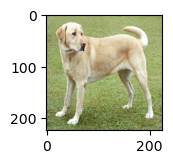

In [26]:
# 방법3
img_data1 = plt.imread('data/sample.jpg')
img_data1 = cv2.resize(img_data1, dsize=(224,224),
                      interpolation=cv2.INTER_NEAREST) # 사이즈 조정

plt.figure(figsize=(1.5,1.5))
plt.imshow(img_data1)
type(img_data1), img_data1.shape

In [28]:
img_data.shape, img_data1.shape

((224, 224, 3), (224, 224, 3))

In [39]:
# 차원 변경 (224,224,3) => (1, 224, 224, 3)하는 방법들
import numpy as np
a = np.array([1,2,3])
print('a의 shape :', a.shape)
# a의 shape (3,) => (1,3) ; newaxis를 이용한 축추가, reshape을 이용한 shape
print('a 배열의 축 추가(3행1열) :\n', a[:, np.newaxis])
print('a 배열의 축 추가(1행3열) :', a[np.newaxis, :])
print('a 배열의 축 추가(1행3열) :', a[np.newaxis, ...])
print('a 배열의 reshape :', a.reshape(-1, 3))

a의 shape : (3,)
a 배열의 축 추가(3행1열) :
 [[1]
 [2]
 [3]]
a 배열의 축 추가(1행3열) : [[1 2 3]]
a 배열의 축 추가(1행3열) : [[1 2 3]]
a 배열의 reshape : [[1 2 3]]


In [42]:
# 예측하기
pred = model.predict(img_data[np.newaxis, ...])
pred.argmax()

1/1 [==============================] - 0s 18ms/step


208

In [45]:
# 예측하기
pred = model.predict(img_data1[np.newaxis, ...])
pred.argmax()

1/1 [==============================] - 0s 18ms/step


208

In [49]:
from tensorflow.keras.applications.vgg19 import decode_predictions
result = decode_predictions(pred, top=5)[0]
for row in result:
    print("{}일 확률 : {}%".format(row[1], round(row[2]*100,2) ))

Labrador_retriever일 확률 : 75.25%
Weimaraner일 확률 : 13.01%
kuvasz일 확률 : 2.97%
Great_Dane일 확률 : 2.02%
bloodhound일 확률 : 1.5%


# 4. 인셉션 모듈
- 교안 55pt
    - 1x1 컨볼루션을 하는 이유 : 채널 수를 줄여 연산속도를 높이려고

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate

In [3]:
model_input = Input(shape=(28,28,3))
pre = Dense(192)(model_input) # => 28*28*192
conv1 = Conv2D(64,  # 커널(필터) 갯수
               1,   # 커널 사이즈
               padding='same')(pre)
conv2 = Conv2D(128, 3, padding='same')(pre)
conv3 = Conv2D(32, 5, padding='same')(pre)
pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre)
model_out = concatenate([conv1, conv2, conv3, pool])
model = Model(inputs=model_input, outputs=model_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 28, 28, 192)  768         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 64)   12352       ['dense_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 128)  221312      ['dense_1[0][0]']                
                                                                                            

- GoogLeNet 중 Inception 모듈, Bottle Neck 구조
- GoogLeNet에서 소개된 핵심 요소로, 이미지 분류와 같은 작업에서 효율적이고 강력한 성능을 제공

```
![image](image/인셉션모듈.png)
```
<img src="image/인셉션모듈.png" alt="image" width="600">

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate
model_input = Input(shape=(28,28,3))
pre = Dense(192)(model_input)

conv1 = Conv2D(64, 1, padding='same')(pre)

conv2_1 = Conv2D(96, 1, padding='same')(pre)
conv2   = Conv2D(128, 3, padding='same')(conv2_1)

conv3_1 = Conv2D(16, 1, padding='same')(pre)
conv3   = Conv2D(32, 5, padding='same')(conv3_1)

pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre)
conv4 = Conv2D(32, 1, padding='same')(pool)

model_output = concatenate([conv1, conv2, conv3, conv4])

model = Model(inputs=model_input, outputs=model_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 28, 28, 192)  768         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 96)   18528       ['dense[0][0]']                  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 16)   3088        ['dense[0][0]']                  
                                                                                              

# 5. Residual block

```
![Residual Block](image/residual_block.png)
```
<img src="image/residual_block.png" alt="Residual Block" width="200" style="float:left;">

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, add
model_input = Input(shape=(28,28,3))

x = Conv2D(64, 3, padding='same', activation='relu')(model_input)

# residual block
conv = Conv2D(32, 3, padding='same', activation='relu')(x)
conv = Conv2D(64, 3, padding='same', activation='relu')(conv)
y = add([conv, x])
y = Activation('relu')(y)

model_output = Conv2D(64, 3, activation='relu')(y)

model = Model(inputs = model_input, outputs=model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   18464       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_4[0][0]']               
                                                                                              

# 6. 케라스 모델 가져오기

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np

model = ResNet50()
# weights=None : 랜덤값으로 초기화된 상태의 가중치
# weights='imagenet'(기본값) : imagenet 데이터로 학습이 끝난 가중치 (224,224,3 이미지->1000 분류)
# model.summary()

In [5]:
json_str = model.to_json()
# json_str
with open('model/model.json', 'w') as json_file:
    json_file.write(json_str)

In [9]:
from tensorflow.keras.models import model_from_json
with open('model/model.json', 'r') as f:
    json_str2 = f.read()
model2 = model_from_json(json_str2)#json으로 가져올 경우 구조만 가져옴. 학습을 새로 해야 함
# model2.summary()

In [42]:
# 이미지를 예측하기 위해 이미지 파일을 넘파이 배열로 가져오는 방법 4가지
# 방법1
import cv2
img_cv = cv2.imread('data/sample.jpg', cv2.IMREAD_COLOR) # 넘파이 배열(BGR포맷)
img_cv2 = cv2.resize(img_cv, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
img_data = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
print('방법1(모두 넘파이) :', img_data.shape, img_cv2.shape, img_cv.shape)

# 방법2
from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg', target_size=(224,224)) # Image 타입
img_data = image.img_to_array(img) # 넘파이로 변경
print('방법2(Image타입으로 읽어 넘파이로 변환) :', img_data.shape, type(img))

# 방법3
from matplotlib import pyplot as plt
import cv2
img_plt = plt.imread('data/sample.jpg') # 넘파이배열
img_data = cv2.resize(img_plt, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
print('방법3(모두 넘파이) :', img_data.shape, img_plt.shape)

# 방법4
from PIL import Image # pip install pillow
import numpy as np
import cv2
imageFile = Image.open('data/sample.jpg') # 이미지파일
img_numpy = np.array(imageFile) # 넘파이로 변경
img_data = cv2.resize(img_numpy, dsize=(224,224), interpolation=cv2.INTER_NEAREST)
print('방법4 :', img_data.shape)

방법1(모두 넘파이) : (224, 224, 3) (224, 224, 3) (577, 700, 3)
방법2(Image타입으로 읽어 넘파이로 변환) : (224, 224, 3) <class 'PIL.Image.Image'>
방법3(모두 넘파이) : (224, 224, 3) (577, 700, 3)
방법4 : (224, 224, 3)


In [43]:
# 모델 사용하기
# 모델 예측시 매개변수로 들어갈 데이터의 축 추가
# 방법1
x = np.expand_dims(img_data, axis=0)
print('방법1 :', x.shape)
# 방법2
x = img_data[np.newaxis, ...]
print('방법2 :', x.shape)
# 방법3
x = img_data[np.newaxis, :]
print('방법3 :', x.shape)
# 방법4
x = img_data.reshape(-1, 224, 224, 3)
print('방법4 :', x.shape)

방법1 : (1, 224, 224, 3)
방법2 : (1, 224, 224, 3)
방법3 : (1, 224, 224, 3)
방법4 : (1, 224, 224, 3)


In [44]:
pred = model.predict(x)
pred.argmax()

1/1 [==============================] - 0s 36ms/step


208

In [45]:
decode_predictions(pred, top=3)

[[('n02099712', 'Labrador_retriever', 0.115230285),
  ('n02108089', 'boxer', 0.11239108),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.10665773)]]

# 7. 전이학습

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
resnet_model = ResNet50(input_shape=(200,200,3),
                include_top=False) # 모델의 최상위 계층은 포함하지 않고 가져옴. 전이학습시 사용
resnet_model.trainable = True # 가중치의 업데이트 허용
# resnet_model.trainable = False : 기존의 ResNet50의 가중치는 고정. 새로 추가된 가중치만 업데이트

model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 126,352,259
Trainable params: 126,299,139
Non-trainable params: 53,120
_________________________________________________________________
